# EE 379K: Lab 9

## Rohan Nagar and Wenyang Fu

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import cross_val_score

%matplotlib inline

In [5]:
def show_feature_dist(df):
    """ Plot the distribution for each feature. """
    fig = plt.figure(figsize=(20, 5))
    cols = 5
    rows = np.ceil(float(df.shape[1]) / cols)
    for i, col in enumerate(df.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(col)
        if df.dtypes[col] == np.object:
            df[column].value_counts().plot(
                kind="bar", axes=ax)
        else:
            df[col].hist(axes=ax)
            plt.xticks(rotation="vertical")
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.show()

In [25]:
def to_file(filename, preds):
    with open(filename, 'w') as f:
        f.write('Id,Probability\n')
        for num, pred in zip(range(1,101504), preds):
            f.write('{},{}\n'.format(num, pred))

# Question 1

One of the features we gave you in the InClass Kaggle competition 
is a noisy version of another. Specifically, Gaussian iid noise was added.

Find these two features and find the mean and variance of the added noise.

In [6]:
train_inclass = pd.read_csv('data/train_inclass.csv')
test_inclass = pd.read_csv('data/test_inclass.csv')

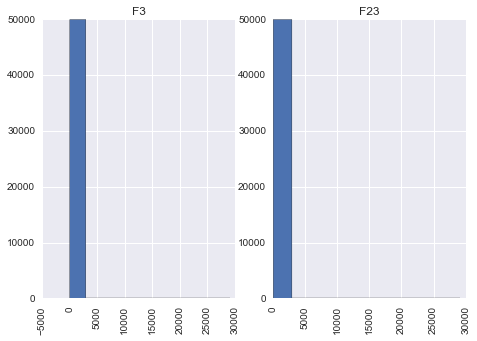

In [7]:
show_feature_dist(train_inclass.ix[:, ['F3', 'F23']])

In [ ]:
# TODO.....

# Question 2

As we explained in lecture, the InClass competition data came from 
https://www.kaggle.com/c/GiveMeSomeCredit

You can now double the training data and you have a new validation set using the leaderboard of this Kaggle competition.

You can also look at `Data Dictionary.xls` to find what each of the features are exactly.

Train your models on the additional data and validate using the private LB of that competition. How do the optimal hyperparameters parameters change? Are the winning XGB parameters still better?

Report your Private LB score and include a screenshot of your submissions in your report.

In [14]:
train = pd.read_csv('data/cs-training.csv', index_col=0)
test = pd.read_csv('data/cs-test.csv', index_col=0)

In [15]:
# Drop dependent variable in test
test = test.drop(['SeriousDlqin2yrs'], axis=1)

In [16]:
# Fill missing with mean
train = train.fillna(cs_train.mean())
test = test.fillna(cs_train.mean())

# Question 3 

`Data Dictionary.xls` explains that you are making your decisions on giving loans using the Total balance on credit cards, the Monthly debt payments, the number of mortgage loands of the individual etc. You are now asked to tell a story from this dataset.

## Part A

Fit a simple logistic regression model and report which features are important (and how they influence the deliquency chance). Discuss what is expected and what is surprising. See how regularization changes the importance of features.

Would you expect that the number of dependents to have a postive or negative effect in deliquency probability? Discuss what you think and what the data says.

## Part B

Look at your best models (in terms of LB AUC). Try to perform feature interpretability for them. Are the results consistent with interpreting a simple logistic regression?

# Question 4

The Age Discrimination in Employment Act (ADEA) forbids age discrimination against people who are age 40 or older, see 
https://www.eeoc.gov/laws/types/age.cfm

Are your models considering age as a factor of influence?

Fit a model for people over 40 or 50 and a model for younger people. Are the two models different?

In [24]:
# Split on age
train_young = train[train.age <= 40]
train_old = train[train.age > 40]

test_young = test[test.age <= 40]
test_old = test[test.age > 40]

# Seperate dependent and independent
X_train_young = train_young.drop(['SeriousDlqin2yrs'], axis=1)
y_train_young = train_young['SeriousDlqin2yrs']

X_train_old = train_old.drop(['SeriousDlqin2yrs'], axis=1)
y_train_old = train_old['SeriousDlqin2yrs']

In [29]:
# Young model
xg = xgb.XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=155,
                       min_child_weight=0.6, subsample=1.0, colsample_bytree=0.45)

score = cross_val_score(xg, X=X_train_young, y=y_train_young, scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
print(score.mean())

[ 0.80309304  0.80742561  0.80765957  0.81825866  0.81428164  0.80780395
  0.81772166  0.81988235  0.80743837  0.80759117]
0.811115602013


In [30]:
# Old model
xg = xgb.XGBClassifier(max_depth=8, learning_rate=0.3, n_estimators=155,
                       min_child_weight=0.6, subsample=1.0, colsample_bytree=0.45)

score = cross_val_score(xg, X=X_train_old, y=y_train_old, scoring='roc_auc', cv=10, n_jobs=-1)
print(score)
print(score.mean())

[ 0.84839258  0.85353971  0.84613665  0.84599402  0.84436367  0.85257815
  0.84813671  0.85349828  0.84802703  0.87025874]
0.851092553603


### Discussion

We can see that a model with the same parameters does much better on the set of older people than on the set of younger people. Age is clearly an influence factor in this dataset. We can use a RandomizedSearch to see if different parameters are selected for models.

In [31]:
def print_cv(model, name):
    print("Best parameter set found on {} model:\n".format(name))
    print(model.best_params_)
    print()
    for params, mean_score, scores in model.grid_scores_:
        print("{0:.3f} (+/-{1:.03f}) for {2}".format(mean_score, scores.std() * 2, params))
    print()

In [32]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'max_depth': [6, 8],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [200],
    'min_child_weight': [1/(0.95**(1/2))],
    'colsample_bytree': [0.4, 0.5]
}

xg_clf = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=5, cv=5, n_jobs=-1, scoring='roc_auc')
xg_clf.fit(X_train_young, y_train_young)
print_cv(xg_clf, 'young')

xg_clf = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=5, cv=5, n_jobs=-1, scoring='roc_auc')
xg_clf.fit(X_train_old, y_train_old)
print_cv(xg_clf, 'old')

Best parameter set found on young model:

{'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'max_depth': 6}

0.837 (+/-0.007) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'max_depth': 6}
0.825 (+/-0.010) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 8}
0.824 (+/-0.009) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'max_depth': 8}
0.836 (+/-0.008) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 8}
0.831 (+/-0.008) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'max_depth': 6}



/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best parameter set found on old model:

{'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'max_depth': 8}

0.868 (+/-0.010) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.5, 'max_depth': 8}
0.863 (+/-0.009) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'max_depth': 8}
0.868 (+/-0.010) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 6}
0.868 (+/-0.009) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'max_depth': 8}
0.866 (+/-0.011) for {'n_estimators': 200, 'min_child_weight': 1.0259783520851542, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'max_depth': 6}



/Users/rohannagar/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Discussion

Again, we see that when seperated by age, the model with older people performs much better. Also, different paramters are selected. In the younger model, `max_depth` was chosen to be 6, while the older model chose `max_depth` as 8. If we had searched over more parameter values, the models would likely be completely different.

## Part B

As a law-maker do you think that forcing age and number of dependents to be forbidden features is a good idea for this problem? Try to base your discussion on what you discover from the data.

## Answer

I think that from a law point of view, those features should be forbidden no matter what the data says. Age should not be considered when deciding if a person can get a loan or not, because that does classify as age discrimination. Also, if we are to not discriminate for people 40 or older, we should not discriminate based on any age value.

According to the data, knowing the age can be valuable in predicting financial distress. This is clear from the work we did in part A. Since there is such a boost in performace for a model predicting on only people over the age of 40, this means that using their age is very helpful to the model. This may seem like a good idea since we get a better AUC ROC score, but in fact this is leading to age discrimination. As a law-maker, I would not feel comfortable knowing that we can predict so much better for people over age 40. This may be generalization and can lead to discrimination based on a person's age.

Because of this, I think that it would be a good idea (as a law-maker) to make age and the number of dependents to be forbidden features. However, from a data perspective (disregarding law), knowing the age can help your models a lot.